# Solving i.v.p.'s using tools provided by Python

## What we did in AE3's last exercise.

In AE3 we learned about numerical methods for soving the first order i.v.p.
$$\frac{dy}{dt}=f(t,y),\quad y(t_0)=y_0.$$
(Note: In line with common standards, we have changed the name of the independent variable from $x$ to $t$).

The last thing we did was to implement a "fourth order Runge-Kutta method", like this:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rk4(f,T,y0) :
    """The function 'rk4' takes three arguments:
    A function f of two variables, an array T of t-values and an initial y-value y0.
    It returns an array of corresponding y-values, starting with y0"""
    l = len(T)              
    y = np.zeros(l)         
    y[0] = y0               
    for k in range(1,l) :    
        h = T[k]-T[k-1]
        k1 = f(T[k-1],y[k-1])
        k2 = f(T[k - 1] + h / 2, y[k - 1] + k1 * h / 2)
        k3 = f(T[k - 1] + h / 2, y[k - 1] + k2 * h / 2)
        k4 = f(T[k - 1] + h, y[k - 1] + k3 * h)
        y[k] = y[k-1]+(k1+2*k2+2*k3+k4)/6*h
    return y     

We illustrated the power of this method by using a relatively large step size ($\Delta t=0.5$) to approximate the solution of the i.v.p.
$$\frac{dy}{dt}=y-t^2,\quad y(0)=1,$$
on the interval $[0,3]$. We can compare the result to the the exact solution, which we know is
$$y(t)=t^2+2t+2-e^t.$$

In [3]:
def f(t,y) :
    return y-t**2   # The RHS of the d.e.

def exact(t) :
    return t**2+2*t+2-np.exp(t)  # The exact solution of the i.v.p.

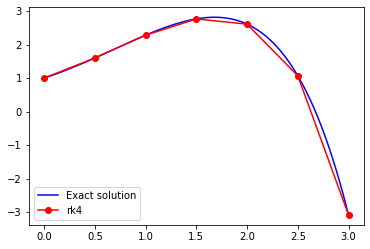

In [11]:
t = np.linspace(0,3,7)   # Seven points gives delta t = 0.5
tt = np.linspace(0,3,1000)  # A lot of points for a smooth plot of the exact solution.

y = rk4(f,t,1)   # The rk4 approximate y-values
yy = exact(tt)     # The y-values obtained from the exact solution.

plt.clf()
plt.plot(tt,yy,'b',label='Exact solution')
plt.plot(t,y,'r-o',label='rk4')
plt.legend()
plt.show()

## Using the scipy.integrate.solve_ivp function instead

The `scipy.integrate` library has the function `solve_ivp` that that does the same thing as our `rk4` function above - but better. By default it uses a fifth order Runge-Kutta method, but this can be changed if you have to. Let's import the function:

In [9]:
from scipy.integrate import solve_ivp

Its syntax is similar but not exactly the same. To do (more or less) the same as the function call

In [10]:
y1 = rk4(f,t,1)

we would do something like

In [12]:
y2 = solve_ivp(f,[0,3],[1],t_eval=t).y[0]

Comparing the output

In [13]:
print(y1)
print(y2)

[ 1.          1.60091146  2.28092957  2.76713129  2.60962007  1.06676954
 -3.08394501]
[ 1.          1.6013198   2.28193123  2.76839926  2.61299633  1.06851322
 -3.08370585]


we see that we get similar, but not exactly the same, answers.

### Understandig the syntax

Let's dig into how it works. Let's start with the function call:

    solve_ivp(f,[0,3],[1],t_eval=t)

- The first argument `f` is the same as for `rk4`. It's the right hand side of the d.e.
- The second argument `[0,3]` is the start- and endpoints of the interval on which we want to approximate the solution.
- The third argument `[1]` is the initial value $y_0$ at the start point. We'll explain later why it is inside a list (why the square brackets are there).
- The last argument `t_eval=t` is optional. It tells `solve_ivp` to return the $y$-values corresponding to the $t$ values in `t`. If you don't specify this, then `solve_ivp` will decide for itself which $y$-values to return.

Without further specification, the function call will return a lot of information. Let's look at the output:

In [14]:
sol = solve_ivp(f,[0,3],[1],t_eval=t)
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 32
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ])
 t_events: None
        y: array([[ 1.        ,  1.6013198 ,  2.28193123,  2.76839926,  2.61299633,
         1.06851322, -3.08370585]])
 y_events: None


That's a lot of information, but the ones we are really interested in are the `t` and `y` parts. We can access them like this:

In [15]:
print(sol.t)
print(sol.y)

[0.  0.5 1.  1.5 2.  2.5 3. ]
[[ 1.          1.6013198   2.28193123  2.76839926  2.61299633  1.06851322
  -3.08370585]]


That's more like it. `sol.t` are the $t$-values (in our example it was specified by `t_eval`) and `sol.y` are the corresponding $y$-values. But there's still one catch. If you look closely, the `y`-array is actually an array inside another array (note the double brackets), so the actual `y` array is the first entry (index 0) of the outer array, i.e.:

In [16]:
print(sol.y[0])

[ 1.          1.6013198   2.28193123  2.76839926  2.61299633  1.06851322
 -3.08370585]


You will soon understand why it's like that. 

We can plot the $y$ values against the $t$ values:

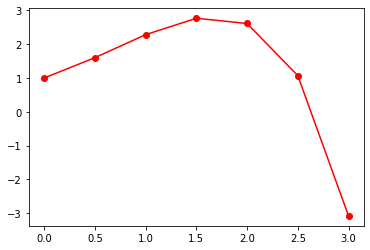

In [17]:
plt.plot(sol.t,sol.y[0],'r-o')
plt.show()

### Some comments:

In our `rk4(f,T,y0)` implementation, the array `T` both dictates which $y$ values are returned, as well as the step length used in the algorithm. The `solve_ivp` function keeps these separate. It decides internally what step length to use and adapts it dynamically to keep the error small. The `t_eval` parameter only specifies what values are used for output (but has no effect on the precision of the algorithm). This can be useful. Let's say we want tho solve our i.v.p. on the interval $[0,3]$ with our initial condition $y(0)=1$, but we're only interested in the calculated y values on $[2.5,3]$, then we could do this:

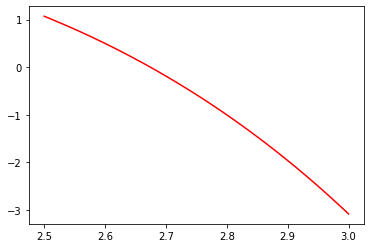

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 32
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([2.5       , 2.50505051, 2.51010101, 2.51515152, 2.52020202,
       2.52525253, 2.53030303, 2.53535354, 2.54040404, 2.54545455,
       2.55050505, 2.55555556, 2.56060606, 2.56565657, 2.57070707,
       2.57575758, 2.58080808, 2.58585859, 2.59090909, 2.5959596 ,
       2.6010101 , 2.60606061, 2.61111111, 2.61616162, 2.62121212,
       2.62626263, 2.63131313, 2.63636364, 2.64141414, 2.64646465,
       2.65151515, 2.65656566, 2.66161616, 2.66666667, 2.67171717,
       2.67676768, 2.68181818, 2.68686869, 2.69191919, 2.6969697 ,
       2.7020202 , 2.70707071, 2.71212121, 2.71717172, 2.72222222,
       2.72727273, 2.73232323, 2.73737374, 2.74242424, 2.74747475,
       2.75252525, 2.75757576, 2.76262626, 2.76767677, 2.77272727,
       2.77777778, 2.78282828, 2.78787879, 2.79292929, 2.7979798 ,
       2.8030303 ,

In [19]:
t=np.linspace(2.5,3,100)  # These are the t-values for which we want to evaluate the corresponding y-values.
                          # Increasing or decreasing the number of points does not affect
                          # the precision of the algorithm.
        
sol=solve_ivp(f,[0,3],[1],t_eval=t)

plt.plot(sol.t,sol.y[0],'r')
plt.show()
sol

## Solving a system of i.v.p.'s

Lets say that instead of a single i.v.p. like this:

$$\frac{dy}{dt}=f(t,y),\quad y(t_0)=y_0,$$

we want to solve a *system* of i.v.p.'s like this:

$$\begin{cases}
\frac{du}{dt} &= f_1(t,u,v)\\
\frac{dv}{dt} &= f_2(t,u,v)\\
u(t_0) &= u_0\\
v(t_0) &= v_0
\end{cases}$$

*Not a problem*

Take for example this system:

$$\begin{cases}
\frac{du}{dt} &= tuv,\\
\frac{dv}{dt} &= u,\\
u(0) &= 1\\
v(0) &= 2
\end{cases}$$

If we want to plot the solutions $u(t)$ and $v(t)$ on the interval $[0,1]$, this will do the trick:

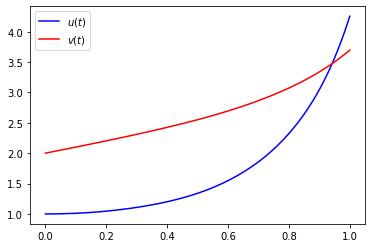

In [20]:
def F(t,Y) :             # This is how we define the right hand sides of  the system
    dudt = t*Y[0]*Y[1]
    dvdt = Y[0]
    return (dudt,dvdt)

t=np.linspace(0,1,100)  
sol = solve_ivp(F,[0,1],[1,2],t_eval=t)

plt.plot(sol.t,sol.y[0],'b',label=r'$u(t)$')
plt.plot(sol.t,sol.y[1],'r',label=r'$v(t)$')
plt.legend()
plt.show()


## What did we just do.

The syntax is essentially the same. This is what we did.

    sol = solve_ivp(F,[0,1],[1,2],t_eval=t)

- The first argument `F` is different, since we have two right hand sides instead of one. It's explained below.
- The second argument works the same. `[0,1]` are the start- and endpoints.
- The third argument `[1,2]` is now a list of *two* initial values instead of one.
- `t_eval` works the same.
- The output sol.y now contains *two* arrays instead of one. `sol.y[0]` are the calculated values for $u$ and `sol.y[1]` are the calculated values for $v$


To specify the right hand sides of the system

$$\begin{cases}
\frac{du}{dt} &= f_1(t,u,v)\\
\frac{dv}{dt} &= f_2(t,u,v)\\
\end{cases}$$

the function `F` that we pass to `solve_ivp` works like this:

`F(t,Y)` takes two arguments: 

- `t` is the independent variable .
- `Y` is an array or list whose first entry `Y[0]` represents the first dependent variable  and whose second entry `Y[1]` represents the second dependent variable .

`F(t,Y)` returns a tuple (an ordered pair). The first giving us the function value `f_1(t,u,v)` and the second giving us `f_2(t,u,v)`, so for our example system

$$\begin{cases}
\frac{du}{dt} &= tuv,\\
\frac{dv}{dt} &= u,\\
\end{cases}$$

the corresponding `F` is

    def F(t,Y) :            
        dudt = t*Y[0]*Y[1]
        dvdt = Y[0]
        return (dudt,dvdt)
        
In AE 4 we will solve a *second order* initial value problems by rewriting it as system of first order i.v.p.'s, and then apply `solve_ivp` like we just described.

**If all this is a bit overwhelming, don't worry. AE4 actually has very little programming in it. You will just be asked to fill in some missing details here and there. Your main task will instead be to interpret the results.**

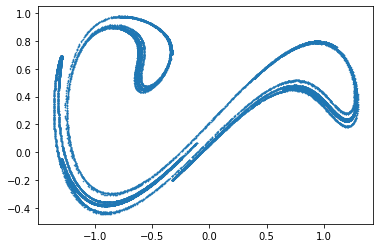

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def F(t,Y) :
    dydt = Y[1]
    dvdt = -0.3*Y[1]+Y[0]-Y[0]**3+gamma*np.cos(1.2*t)
    return (dydt,dvdt)

gamma = 0.5

T=2*np.pi/1.2

# t = np.linspace(0,1,)
# Create a suitable array t for us to use as t_eval below.
# We want to plot the calculated solution values for values of t starting at 100T,
# equally spaced a distance T from each other and all in the interval [100T,50000T)
# The function np.arange() is useful here.

# Complete the row below.
t = np.arange(100*T,50000*T, T)

ysol = solve_ivp(F,[0,50000*T],[1,0],t_eval=t,max_step=0.1)

plt.clf()

plt.plot(ysol.y[0],ysol.y[1],'.',markersize=1)

plt.show()

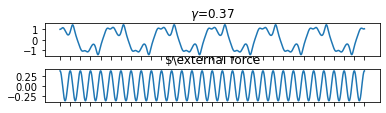

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def F(t,Y) :
    dydt = Y[1]
    dvdt = -0.3*Y[1]+Y[0]-Y[0]**3+gamma*np.cos(1.2*t)
    return (dydt,dvdt)

T = 2*np.pi/1.2
t = np.linspace(0,30*T,5000)

# gamma = 0.2
# ysol_a = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)

# gamma = 0.28
# ysol_b = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)

gamma = 0.37
ysol_c = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)

# gamma = 0.5
# ysol_d = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)

# gamma = 0.65
# ysol_e = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)

external_force_y = gamma*np.cos(1.2*t)



plt.clf()

# plt.subplot(511)
# plt.xticks(np.arange(0,31*T,T),[])
# plt.plot(ysol_a.t,ysol_a.y[0])
# plt.title(r'$\gamma$=0.2')


# plt.subplot(512)
# plt.xticks(np.arange(0,31*T,T),[])
# plt.plot(ysol_b.t,ysol_b.y[0])
# plt.title(r'$\gamma$=0.28')
plt.subplot(514)
plt.xticks(np.arange(0,31*T,T),[])
plt.plot(t,external_force_y)
plt.title(r'$\external force')
plt.subplot(513)
plt.xticks(np.arange(0,31*T,T),[])
plt.plot(ysol_c.t,ysol_c.y[0])
plt.title(r'$\gamma$=0.37')
# plt.subplot(514)
# plt.xticks(np.arange(0,31*T,T),[])
# plt.plot(ysol_d.t,ysol_d.y[0])
# plt.title(r'$\gamma$=0.5')
# plt.xticks(np.arange(0,31*T,T),[])
# plt.subplot(515)
# plt.xticks(np.arange(0,31*T,T),np.arange(0,31,1))
# plt.xlabel('t/T')
# plt.plot(ysol_e.t,ysol_e.y[0])
# plt.title(r'$\gamma$=0.65')

plt.subplots_adjust(hspace=0.4)

plt.show()

In [ ]:
t = np.linspace(0,5,1000)
sol = solve_ivp(F,[0,5],[0,0],t_eval=t)

plt.plot(sol.t,sol.y[0],'b',label=r'$y(t)$')

plt.legend()
plt.show()

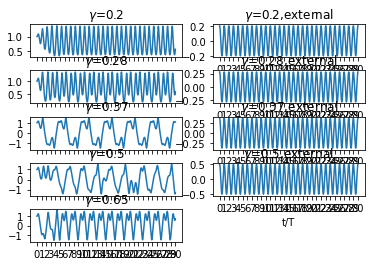

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def F(t,Y) :
    dydt = Y[1]
    dvdt = -0.3*Y[1]+Y[0]-Y[0]**3+gamma*np.cos(1.2*t)
    return (dydt,dvdt)

T = 2*np.pi/1.2
t = np.linspace(0,30*T,5000)

gamma = 0.2
ysol_a = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)
external_force_a = gamma*np.cos(1.2*t)

gamma = 0.28
ysol_b = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)
external_force_b = gamma*np.cos(1.2*t)

gamma = 0.37
ysol_c = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)
external_force_c = gamma*np.cos(1.2*t)

gamma = 0.5
ysol_d = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)
external_force_d = gamma*np.cos(1.2*t)

gamma = 0.65
ysol_e = solve_ivp(F,[0,30*T],[1,0],t_eval=t,max_step=0.1)
external_force_e = gamma*np.cos(1.2*t)

plt.clf()

plt.subplot(5,2,1)
plt.xticks(np.arange(0,31*T,T),[])
plt.plot(ysol_a.t,ysol_a.y[0])
plt.title(r'$\gamma$=0.2')
plt.subplot(5,2,3)
plt.xticks(np.arange(0,31*T,T),[])
plt.plot(ysol_b.t,ysol_b.y[0])
plt.title(r'$\gamma$=0.28')
plt.subplot(5,2,5)
plt.xticks(np.arange(0,31*T,T),[])
plt.plot(ysol_c.t,ysol_c.y[0])
plt.title(r'$\gamma$=0.37')
plt.subplot(5,2,7)
plt.xticks(np.arange(0,31*T,T),[])
plt.plot(ysol_d.t,ysol_d.y[0])
plt.title(r'$\gamma$=0.5')
plt.xticks(np.arange(0,31*T,T),[])
plt.subplot(5,2,9)
plt.xticks(np.arange(0,31*T,T),np.arange(0,31,1))
plt.plot(ysol_e.t,ysol_e.y[0])
plt.title(r'$\gamma$=0.65')
plt.subplot(5,2,2)
plt.xticks(np.arange(0,31*T,T),np.arange(0,31,1))
plt.plot(t,external_force_a)
plt.title(r'$\gamma$=0.2,external')
plt.subplot(5,2,4)
plt.xticks(np.arange(0,31*T,T),np.arange(0,31,1))
plt.plot(t,external_force_b)
plt.title(r'$\gamma$=0.28,external')
plt.subplot(5,2,6)
plt.xticks(np.arange(0,31*T,T),np.arange(0,31,1))
plt.plot(t,external_force_c)
plt.title(r'$\gamma$=0.37,external')
plt.subplot(5,2,8)
plt.xticks(np.arange(0,31*T,T),np.arange(0,31,1))
plt.plot(t,external_force_d)
plt.title(r'$\gamma$=0.5,external')
plt.xlabel('t/T')

plt.subplots_adjust(hspace=0.4)

plt.show()